<a href="https://colab.research.google.com/github/Dkusboori/DJ_Portfolio/blob/my_projects/NLP_Tweets_07152023_(1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import logging

# Set logging level to ERROR to suppress download messages
logging.getLogger('nltk').setLevel(logging.ERROR)

import os
import urllib
import zipfile
import pandas as pd
import numpy as np
import re
import string
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import accuracy_score, classification_report
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelBinarizer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from getpass import getpass
import nltk
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')
from sklearn.utils import shuffle
from tqdm import tqdm
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, Dense, Dropout, LSTM, Conv1D, MaxPooling1D, Flatten, Input
from tensorflow.keras.callbacks import EarlyStopping
import nlpaug.augmenter.word.context_word_embs as aug




[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Dheeraj\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Dheeraj\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Dheeraj\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
# # Set Kaggle Username and API Key
# os.environ['KAGGLE_USERNAME'] = "username" # replace with your Kaggle username
# os.environ['KAGGLE_KEY'] = "kagglekey" # replace with your Kaggle key

# # Download the dataset
# !kaggle datasets download -d crowdflower/twitter-airline-sentiment

# with zipfile.ZipFile("twitter-airline-sentiment.zip","r") as zip_ref:
#     zip_ref.extractall("twitter-airline-sentiment")

# df = pd.read_csv('./twitter-airline-sentiment/Tweets.csv')

### Load the Dataset

In [ ]:
df = pd.read_csv('Tweets.csv')
df.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


### EDA

In [ ]:
df.shape

(14640, 15)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14640 entries, 0 to 14639
Data columns (total 15 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   tweet_id                      14640 non-null  int64  
 1   airline_sentiment             14640 non-null  object 
 2   airline_sentiment_confidence  14640 non-null  float64
 3   negativereason                9178 non-null   object 
 4   negativereason_confidence     10522 non-null  float64
 5   airline                       14640 non-null  object 
 6   airline_sentiment_gold        40 non-null     object 
 7   name                          14640 non-null  object 
 8   negativereason_gold           32 non-null     object 
 9   retweet_count                 14640 non-null  int64  
 10  text                          14640 non-null  object 
 11  tweet_coord                   1019 non-null   object 
 12  tweet_created                 14640 non-null  object 
 13  t

In [ ]:
df.describe()

,tweet_id,airline_sentiment_confidence,negativereason_confidence,retweet_count
count,1.464000e+04,14640.000000,10522.000000,14640.000000
mean,5.692184e+17,0.900169,0.638298,0.082650
std,7.791112e+14,0.162830,0.330440,0.745778
min,5.675883e+17,0.335000,0.000000,0.000000
25%,5.685592e+17,0.692300,0.360600,0.000000
50%,5.694779e+17,1.000000,0.670600,0.000000
75%,5.698905e+17,1.000000,1.000000,0.000000
max,5.703106e+17,1.000000,1.000000,44.000000


In [ ]:
df.isnull().sum()

tweet_id                            0
airline_sentiment                   0
airline_sentiment_confidence        0
negativereason                   5462
negativereason_confidence        4118
airline                             0
airline_sentiment_gold          14600
name                                0
negativereason_gold             14608
retweet_count                       0
text                                0
tweet_coord                     13621
tweet_created                       0
tweet_location                   4733
user_timezone                    4820
dtype: int64

Tweets per sentiment:
negative    9178
neutral     3099
positive    2363
Name: airline_sentiment, dtype: int64


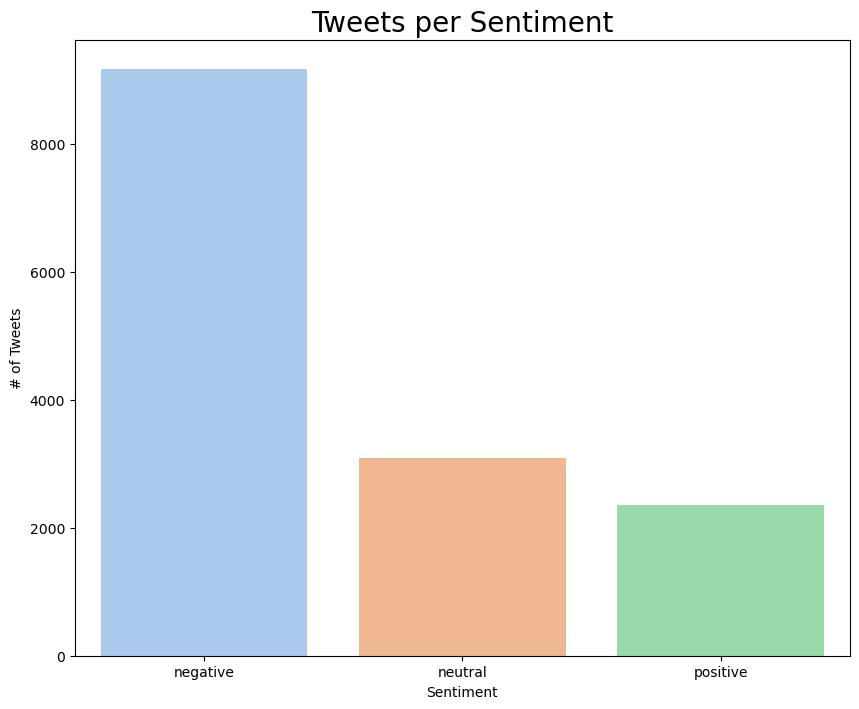

In [ ]:
print("Tweets per sentiment:")
print(df.airline_sentiment.value_counts())

# Define a custom color palette
colors = ['#FF0000', '#00FF00', '#0000FF']

plt.figure(figsize=(10, 8))
ax = sns.countplot(x='airline_sentiment', data=df, order=df.airline_sentiment.value_counts().index, palette="pastel")
ax.set_title('Tweets per Sentiment', fontsize=20)
plt.xlabel('Sentiment')
plt.ylabel('# of Tweets')
plt.show()

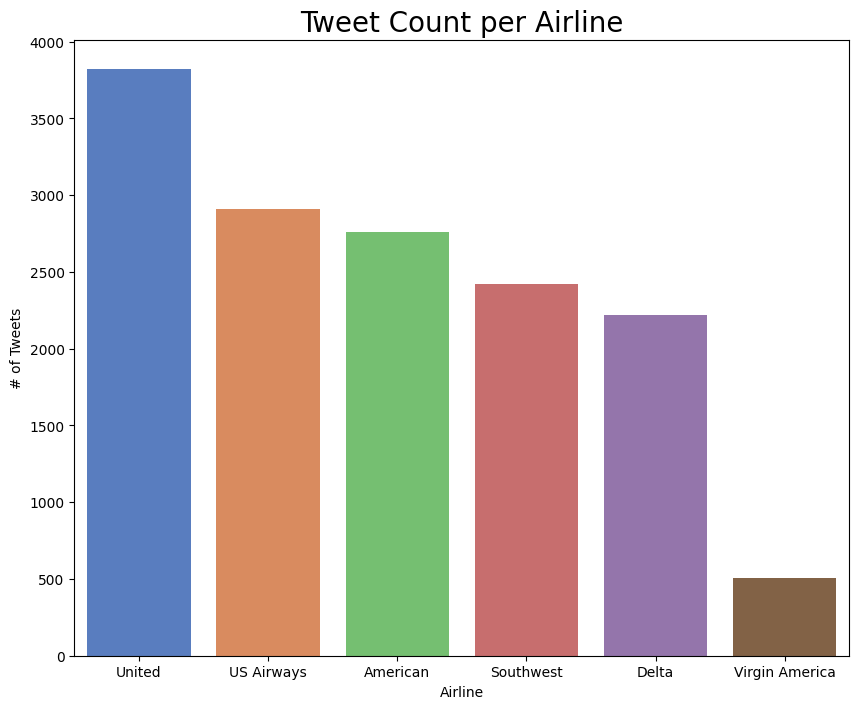

Total Tweet Count vs Airline
United :
negative    2633
neutral      697
positive     492
Name: airline_sentiment, dtype: int64
US Airways :
negative    2263
neutral      381
positive     269
Name: airline_sentiment, dtype: int64
American :
negative    1960
neutral      463
positive     336
Name: airline_sentiment, dtype: int64
Southwest :
negative    1186
neutral      664
positive     570
Name: airline_sentiment, dtype: int64
Delta :
negative    955
neutral     723
positive    544
Name: airline_sentiment, dtype: int64
Virgin America :
negative    181
neutral     171
positive    152
Name: airline_sentiment, dtype: int64


In [ ]:
colors = sns.color_palette('muted', 8)
plt.figure(figsize=(10, 8))
ax = sns.countplot(x='airline', data=df, order=df['airline'].value_counts().index, palette=colors)
ax.set_title('Tweet Count per Airline', fontsize=20)
plt.xlabel('Airline')
plt.ylabel('# of Tweets')
plt.show()

print("Total Tweet Count vs Airline")
airline_list = df['airline'].unique().tolist()
tweet_count = df['airline'].value_counts()
for airline in tweet_count.index:
    print('{} :'.format(airline))
    print(df.loc[df['airline'] == airline, 'airline_sentiment'].value_counts())

Reasons Of Negative Tweets:
Customer Service Issue         2910
Late Flight                    1665
Can't Tell                     1190
Cancelled Flight                847
Lost Luggage                    724
Bad Flight                      580
Flight Booking Problems         529
Flight Attendant Complaints     481
longlines                       178
Damaged Luggage                  74
Name: negativereason, dtype: int64


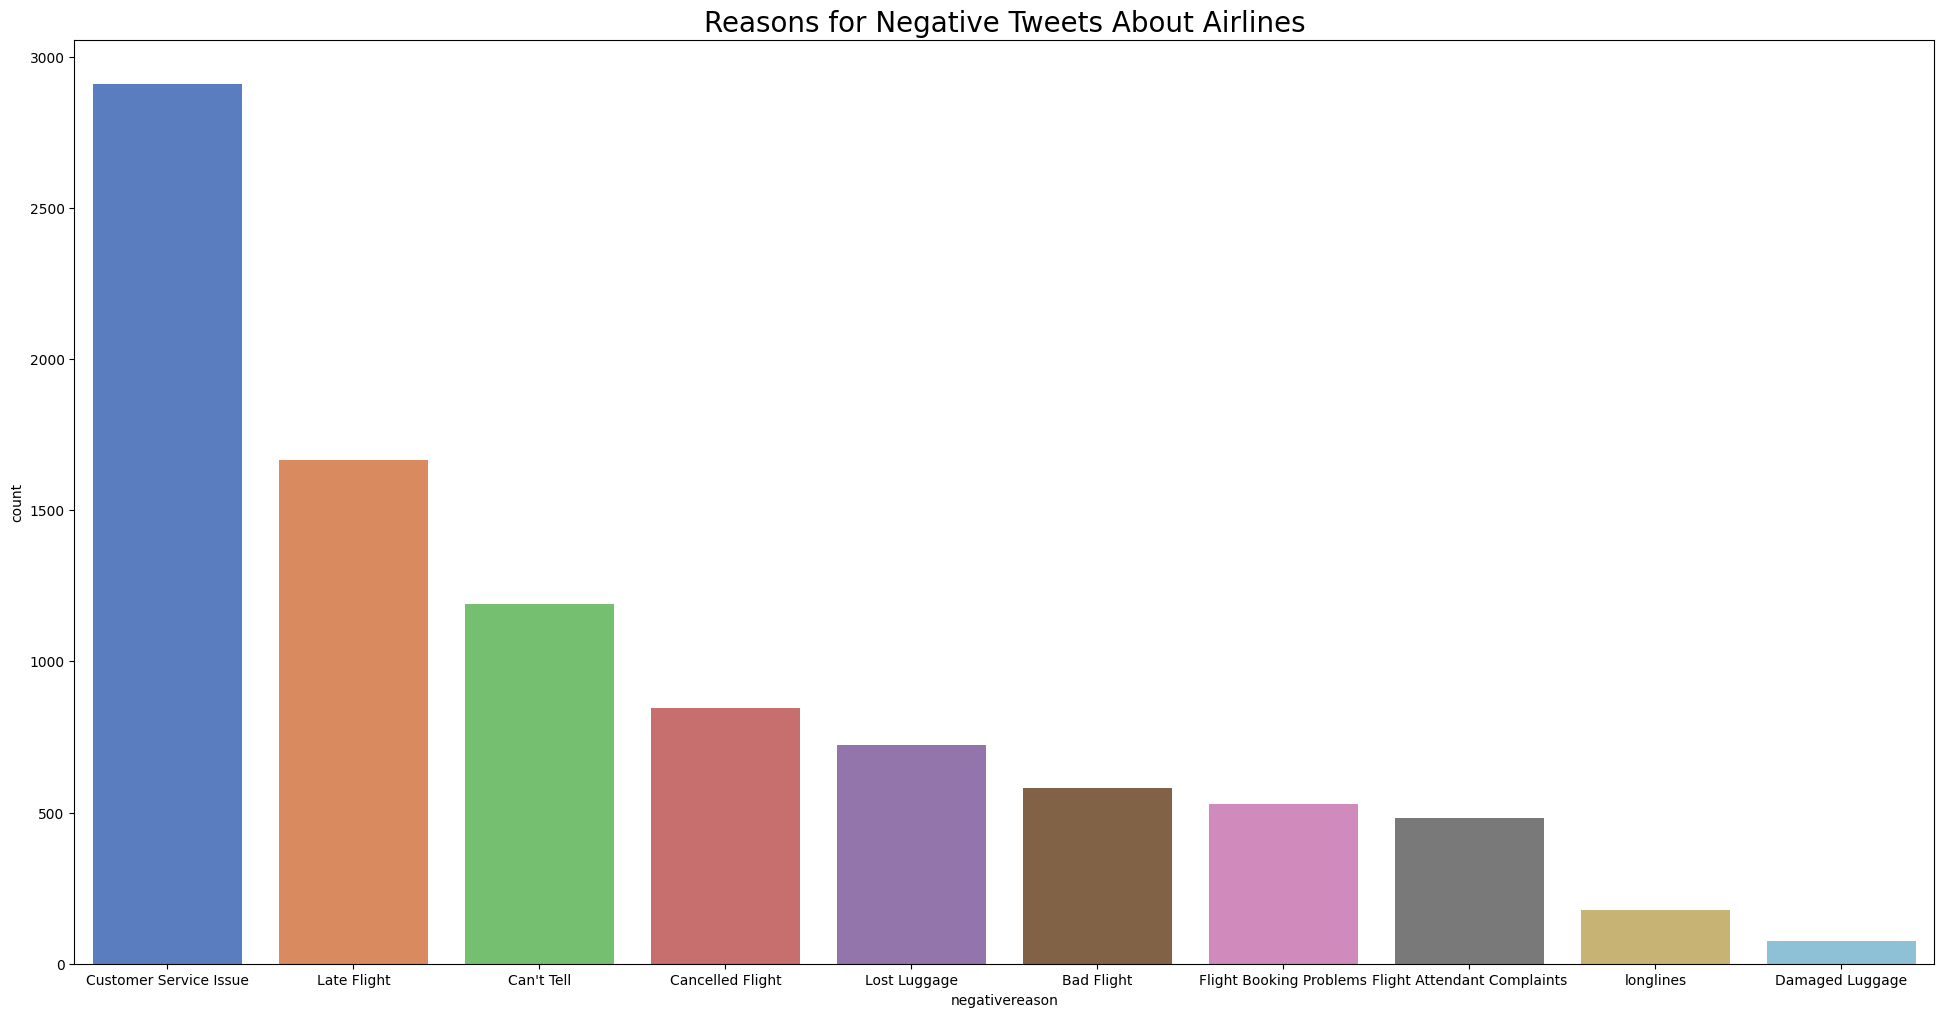

In [ ]:
print('Reasons Of Negative Tweets:')
negative_reason_counts = df['negativereason'].value_counts().sort_values(ascending=False)
print(negative_reason_counts)

plt.figure(figsize=(24, 12))
sns.countplot(x='negativereason', data=df, order=negative_reason_counts.index, palette='muted')
plt.title('Reasons for Negative Tweets About Airlines', fontsize=20)
plt.show()

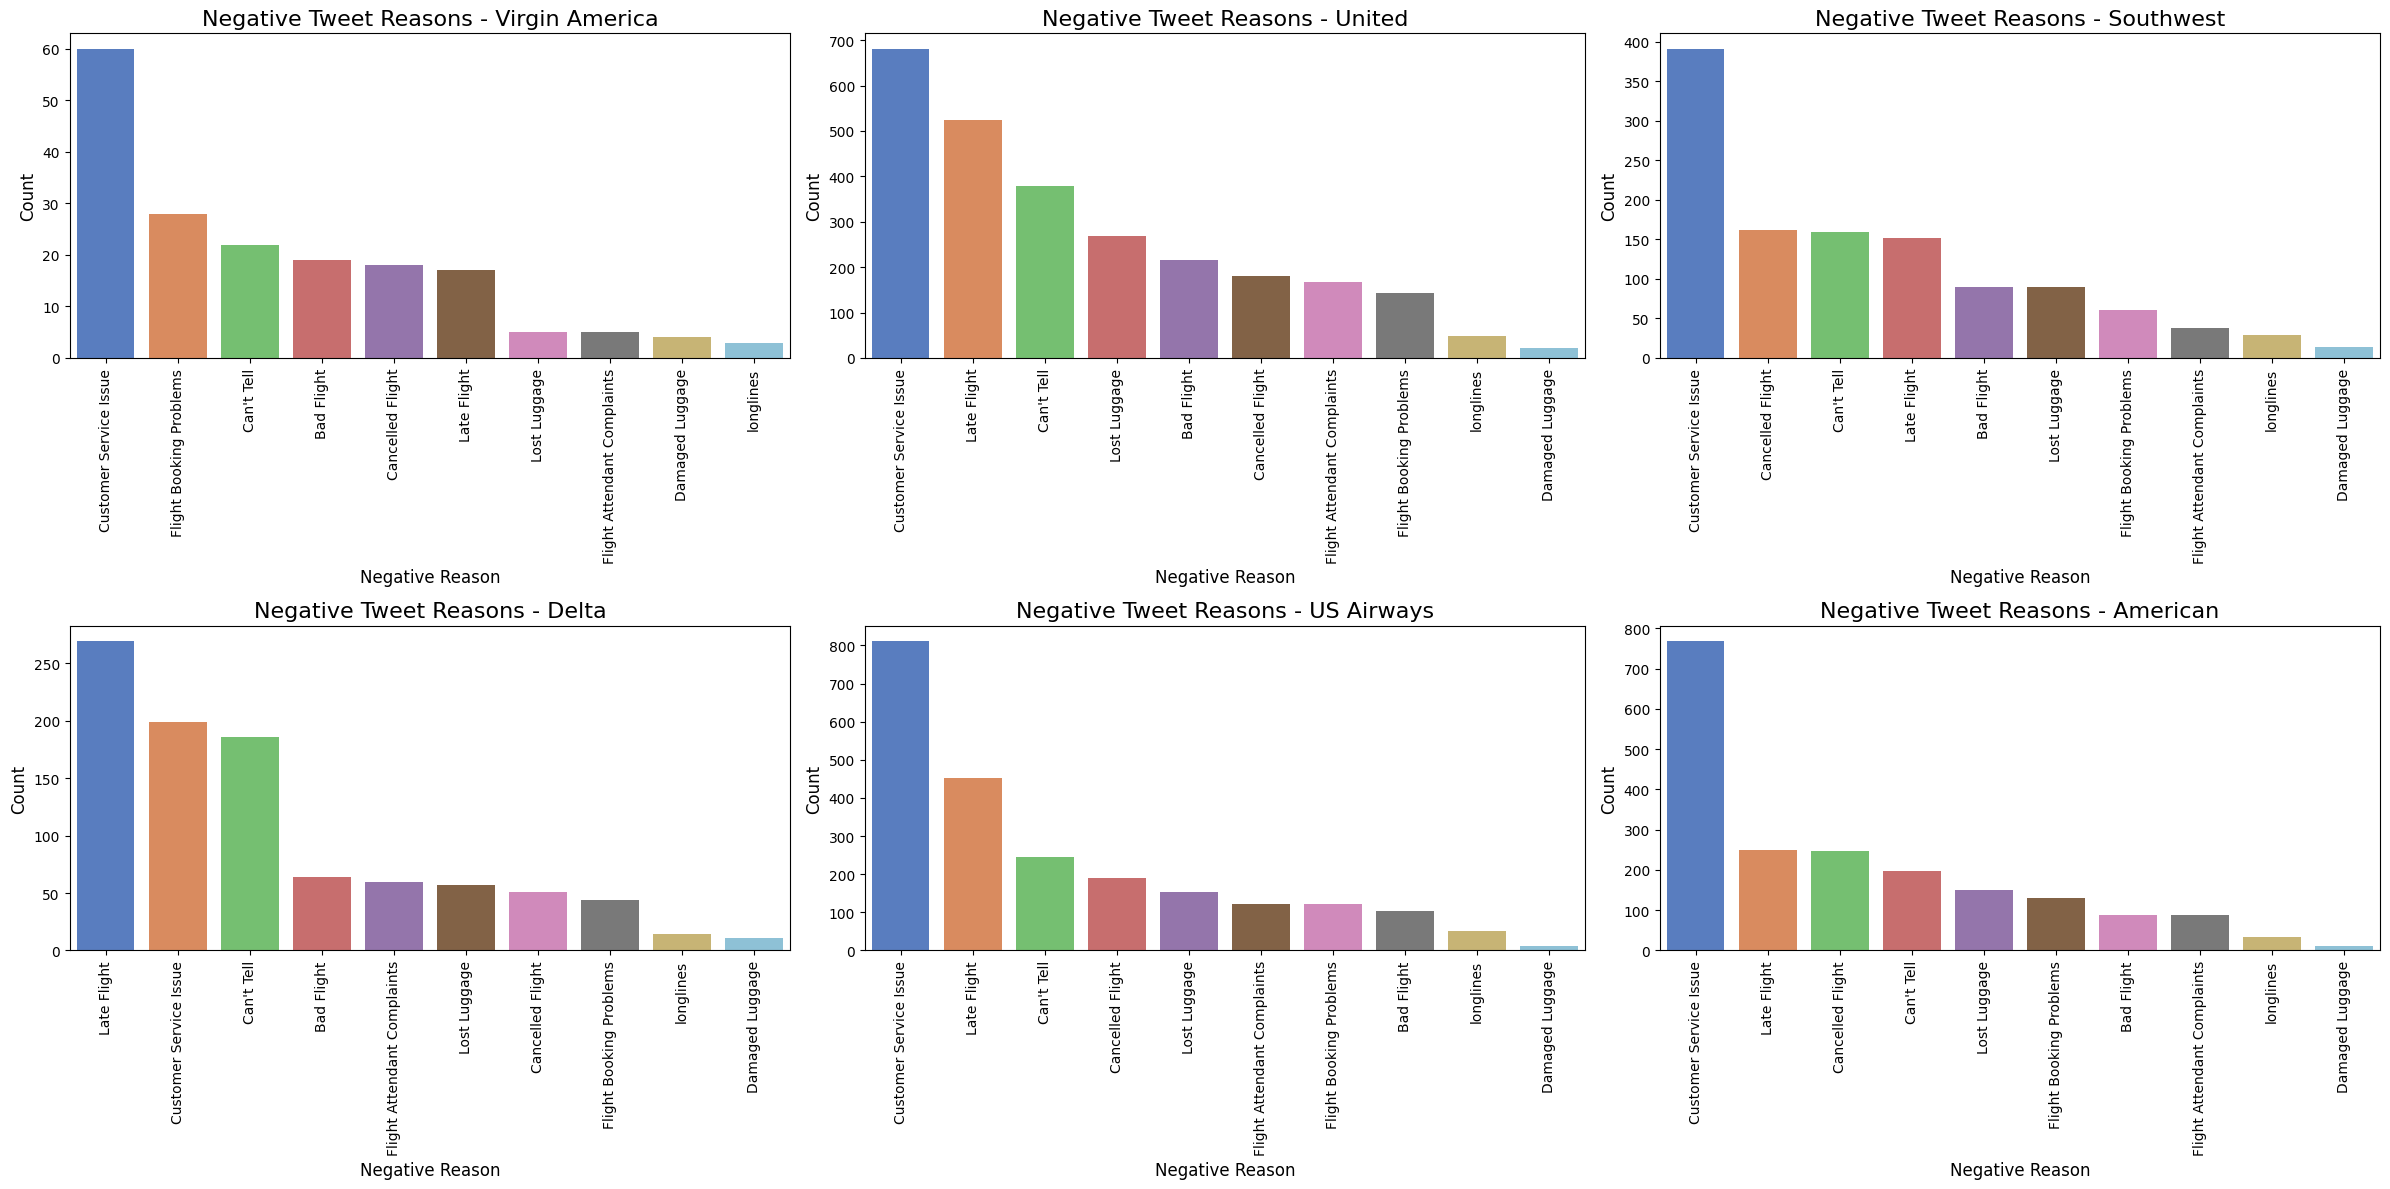

In [ ]:
airlines = df['airline'].unique()

plt.figure(figsize=(24, 12))

for i, airline in enumerate(airlines):
    plt.subplot(2, 3, i+1)
    neg_reason_counts = df[df['airline'] == airline]['negativereason'].value_counts().sort_values(ascending=False)
    sns.countplot(x='negativereason', data=df[df['airline'] == airline], palette='muted', order=neg_reason_counts.index)
    plt.title(f'Negative Tweet Reasons - {airline}', fontsize=16)
    plt.xlabel('Negative Reason', fontsize=12)
    plt.ylabel('Count', fontsize=12)
    plt.xticks(rotation=90)

plt.tight_layout()
plt.show()

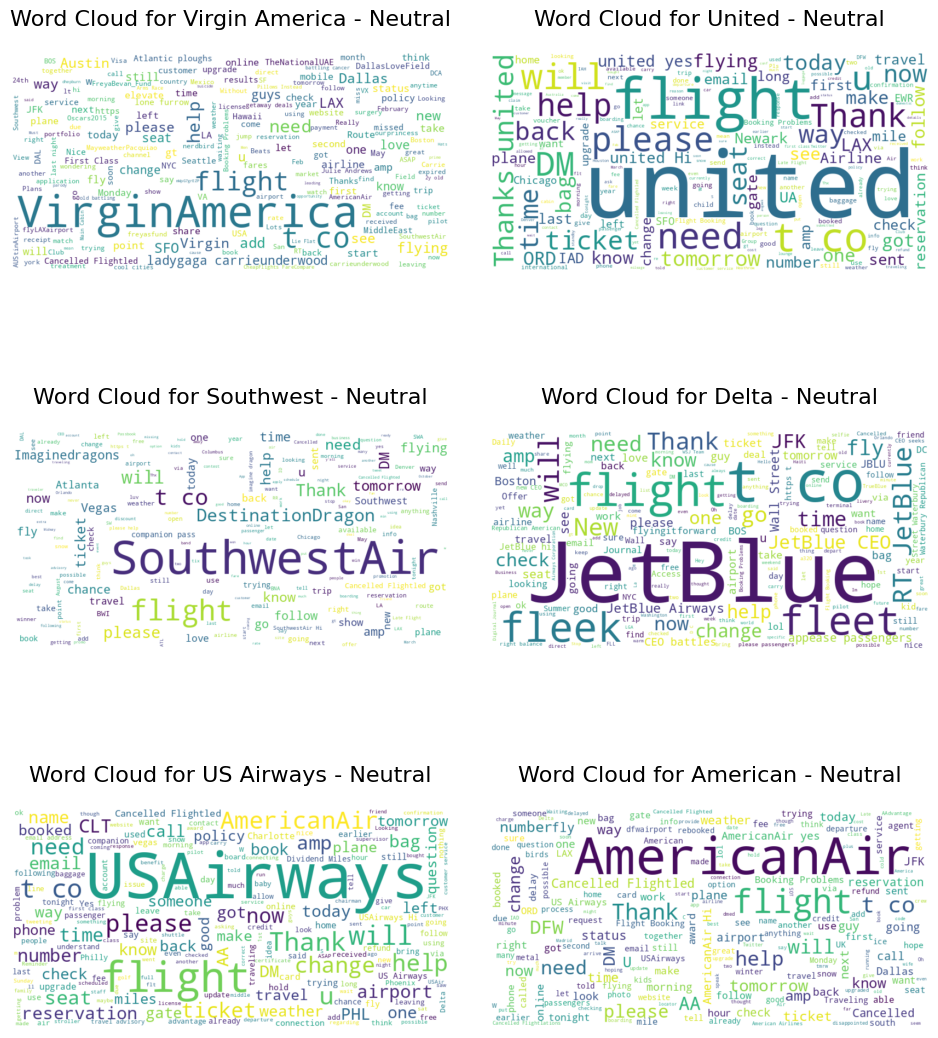

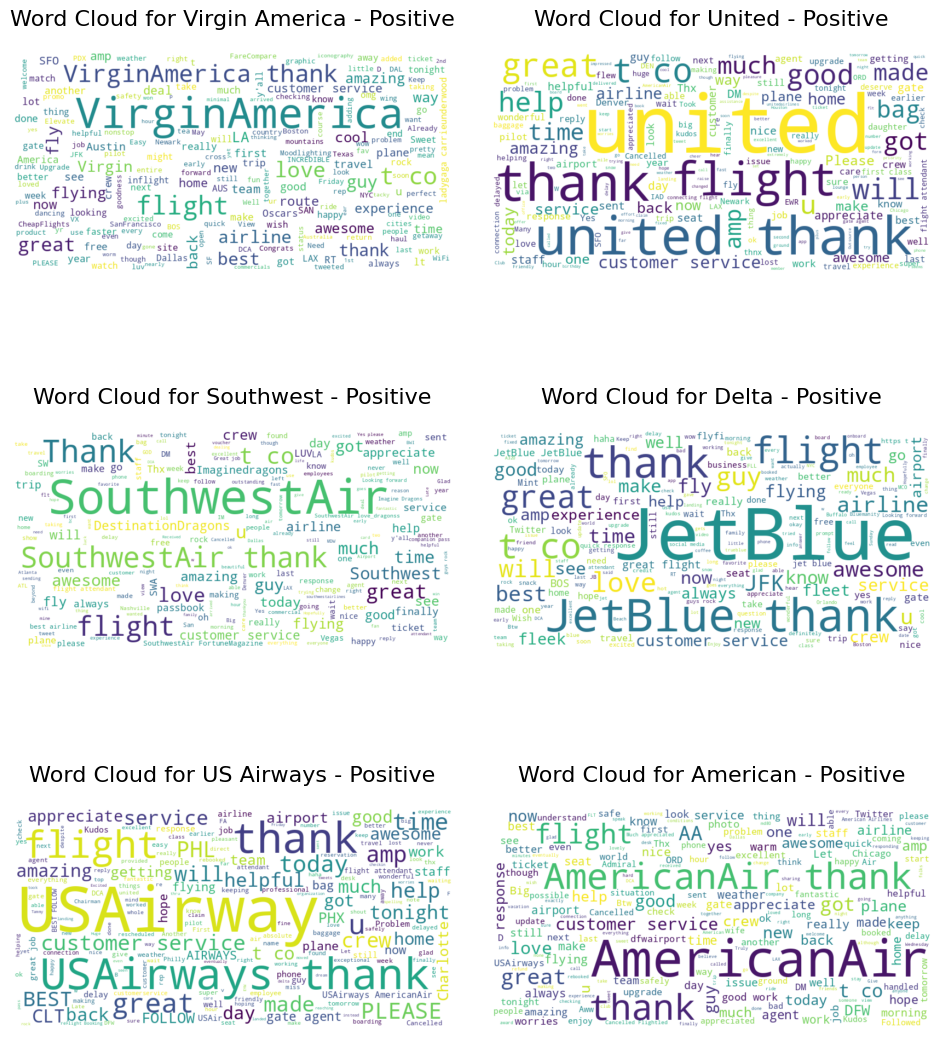

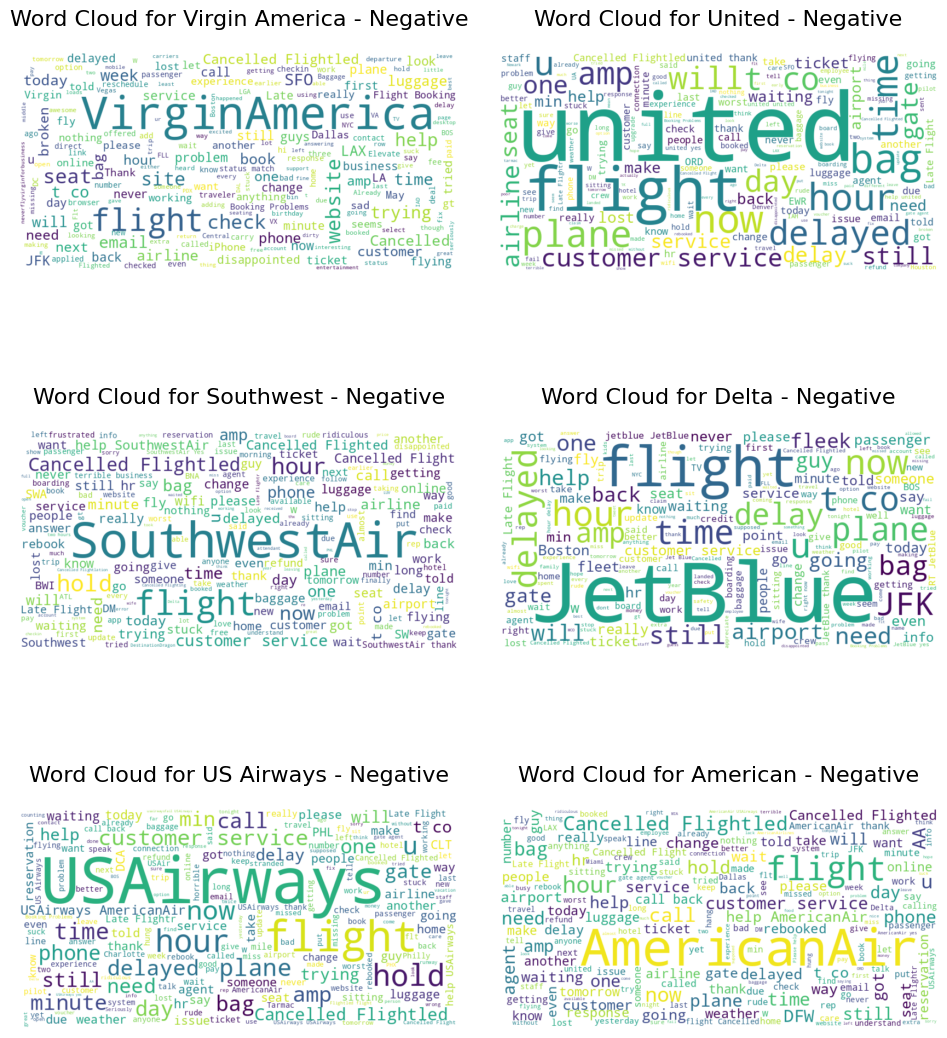

In [ ]:
def generate_and_plot_wordcloud(text, airline, sentiment, subplot_no):
    # Generate word cloud
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

    # Plot word cloud
    plt.subplot(num_airlines // 2 + 1, 2, subplot_no)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f'Word Cloud for {airline} - {sentiment.title()}', fontsize=16, pad=20)  # Add pad for title spacing
    plt.axis('off')

sentiments = df['airline_sentiment'].unique()
airlines = df['airline'].unique()
num_airlines = len(airlines)

for sentiment in sentiments:
    plt.figure(figsize=(10, 16))
    sentiment_airlines = df[df['airline_sentiment'] == sentiment]['airline'].unique()

    for i, airline in enumerate(airlines):
        text = " ".join(df[(df['airline_sentiment'] == sentiment) & (df['airline'] == airline)]['text'])
        generate_and_plot_wordcloud(text, airline, sentiment, i+1)

    plt.tight_layout(pad=3)  # Adjust spacing between subplots
    plt.show()


**Data Preprocessing**

In [ ]:
# Just keeping the required columns
df = df[['text', 'airline_sentiment']]

print(df.head())

                                                text airline_sentiment
0                @VirginAmerica What @dhepburn said.           neutral
1  @VirginAmerica plus you've added commercials t...          positive
2  @VirginAmerica I didn't today... Must mean I n...           neutral
3  @VirginAmerica it's really aggressive to blast...          negative
4  @VirginAmerica and it's a really big bad thing...          negative


**Checking for the length of the words before cleaning the data**

In [ ]:
df['len'] = df['text'].apply(lambda x: len(x))
df.head()

,text,airline_sentiment,len
0,@VirginAmerica What @dhepburn said.,neutral,35
1,@VirginAmerica plus you've added commercials t...,positive,72
2,@VirginAmerica I didn't today... Must mean I n...,neutral,71
3,@VirginAmerica it's really aggressive to blast...,negative,126
4,@VirginAmerica and it's a really big bad thing...,negative,55


**Perform text cleaning**

In [ ]:
def preprocess_text(text):
    # convert to lower case
    text = text.lower()

    # remove numbers
    num_pattern = r'\d+'
    text = re.sub(pattern=num_pattern, repl=" ", string=text)

    # lemmatize
    lemmatizer = WordNetLemmatizer()
    tokens = word_tokenize(text)
    for i in range(len(tokens)):
        lemm_word = lemmatizer.lemmatize(tokens[i])
        tokens[i] = lemm_word
    text = " ".join(tokens)

    # remove punctuations
    text = text.translate(str.maketrans('', '', string.punctuation))

    # remove stopwords
    removed = []
    stop_words = list(stopwords.words("english"))
    tokens = word_tokenize(text)
    for i in range(len(tokens)):
        if tokens[i] not in stop_words:
            removed.append(tokens[i])
    text = " ".join(removed)

    # remove extra whitespaces
    single_char_pattern = r'\s+[a-zA-Z]\s+'
    text = re.sub(pattern=single_char_pattern, repl=" ", string=text)

    return text

# Apply the preprocessing function to each text in the dataframe
df['text'] = df['text'].apply(preprocess_text)


**Checking for the length of the words after cleaning the data**

In [ ]:
df['new_len'] = df['text'].apply(lambda x: len(x))
df.head()

,text,airline_sentiment,len,new_len
0,virginamerica dhepburn said,neutral,35,27
1,virginamerica plus added commercial experience...,positive,72,52
2,virginamerica nt today must mean need take ano...,neutral,71,55
3,virginamerica really aggressive blast obnoxiou...,negative,126,92
4,virginamerica really big bad thing,negative,55,34


**Mapping sentiment to labels**

In [ ]:
label_map = {'neutral': 0, 'negative': 1, 'positive': 2}

df['airline_sentiment'] = df['airline_sentiment'].map(label_map)
df.head()

,text,airline_sentiment,len,new_len
0,virginamerica dhepburn said,0,35,27
1,virginamerica plus added commercial experience...,2,72,52
2,virginamerica nt today must mean need take ano...,0,71,55
3,virginamerica really aggressive blast obnoxiou...,1,126,92
4,virginamerica really big bad thing,1,55,34


In [ ]:
df_train, df_test = train_test_split(df[['text', 'airline_sentiment']], test_size=0.3, random_state=42)

In [ ]:
df_train.head()

,text,airline_sentiment
7717,jetblue flight sxm gt jfk time doe bus leave h...,0
13854,americanair still selling ticket nt rebooked p...,1
11719,usairways called time last three day unaccepta...,1
239,virginamerica sound like fun,2
8582,jetblue statement lufthansa incentive offer st...,0


**Tesing the NaiveBayes model without text augmentation**

In [ ]:
# Vectorizing the text
vectorizer = TfidfVectorizer()
X_train_vec = vectorizer.fit_transform(df_train['text'])
X_test_vec = vectorizer.transform(df_test['text'])

# Encoding the labels
y_train = df_train['airline_sentiment']
y_test = df_test['airline_sentiment']

# Train the Naive Bayes model
naive_bayes_model = MultinomialNB()
naive_bayes_model.fit(X_train_vec, y_train)

# Make predictions
y_train_pred = naive_bayes_model.predict(X_train_vec)
y_test_pred = naive_bayes_model.predict(X_test_vec)

# Check the accuracy of the model
train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)

print(f"Training Accuracy: {train_accuracy*100}%")
print(f"Testing Accuracy: {test_accuracy*100}%")

# Print classification report for training data
print("\nClassification report for training data:\n", classification_report(y_train, y_train_pred))

# Print classification report for testing data
print("\nClassification report for testing data:\n", classification_report(y_test, y_test_pred))

Training Accuracy: 73.47775175644028%
Testing Accuracy: 69.35336976320583%

Classification report for training data:
               precision    recall  f1-score   support

           0       0.91      0.30      0.45      2215
           1       0.71      1.00      0.83      6364
           2       0.95      0.31      0.47      1669

    accuracy                           0.73     10248
   macro avg       0.86      0.54      0.58     10248
weighted avg       0.79      0.73      0.69     10248


Classification report for testing data:
               precision    recall  f1-score   support

           0       0.75      0.14      0.24       884
           1       0.68      0.99      0.81      2814
           2       0.92      0.18      0.30       694

    accuracy                           0.69      4392
   macro avg       0.79      0.44      0.45      4392
weighted avg       0.73      0.69      0.61      4392



In [ ]:
new_df = df_train.copy()
new_df.head()

,text,airline_sentiment
7717,jetblue flight sxm gt jfk time doe bus leave h...,0
13854,americanair still selling ticket nt rebooked p...,1
11719,usairways called time last three day unaccepta...,1
239,virginamerica sound like fun,2
8582,jetblue statement lufthansa incentive offer st...,0


In [ ]:
# !pip install transformers
# !pip install nlpaug

In [ ]:
augmenter = aug.ContextualWordEmbsAug(model_path='bert-base-uncased', action='insert')

In [ ]:
def augmentMyData(df, augmenter, label=0, repetitions=1, samples=900):
    augmented_texts = []
    label_df = df[df['airline_sentiment']==label].reset_index(drop=True)

    for i in tqdm(np.random.randint(0, len(label_df), samples)):
        for _ in range(repetitions):
            augmented_text = augmenter.augment(label_df['text'].iloc[i])
            # if the augmenter returns a list of strings, join them into a single string
            if isinstance(augmented_text, list):
                augmented_text = ' '.join(augmented_text)
            augmented_texts.append(augmented_text)

    data = {'airline_sentiment':label, 'text': augmented_texts}

    aug_df = pd.DataFrame(data)
    df = shuffle(df.append(aug_df).reset_index(drop=True))
    return df


In [ ]:
new_df['airline_sentiment'].value_counts()

1    6364
0    2215
2    1669
Name: airline_sentiment, dtype: int64

In [ ]:
aug_df = augmentMyData(new_df, augmenter, samples=3000)   # Augmenting for label 0
print('\n')
aug_df['airline_sentiment'].value_counts()

100%|██████████| 3000/3000 [21:50<00:00,  2.29it/s]


<ipython-input-25-bc1a692caa23>:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = shuffle(df.append(aug_df).reset_index(drop=True))


1    6364
0    5215
2    1669
Name: airline_sentiment, dtype: int64

In [ ]:
aug_df = augmentMyData(aug_df, augmenter, label=2, samples=3000)  # Augmenting for label 2
print('\n')
aug_df['airline_sentiment'].value_counts()

100%|██████████| 3000/3000 [20:55<00:00,  2.39it/s]


<ipython-input-25-bc1a692caa23>:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = shuffle(df.append(aug_df).reset_index(drop=True))


1    6364
0    5215
2    4669
Name: airline_sentiment, dtype: int64

In [ ]:
aug_df.to_csv('aug_df_tweets.csv')

In [ ]:
# Fit the vectorizer on the augmented training data
vectorizer = TfidfVectorizer()
vectorizer.fit(aug_df['text'])

# Vectorize the augmented training data
X_train_aug_vec = vectorizer.transform(aug_df['text'])

# Vectorize the test data using the same vectorizer
X_test_vec = vectorizer.transform(df_test['text'])

# Get the labels of the augmented training data
y_train_aug = aug_df['airline_sentiment']

# Train the Naive Bayes model on the augmented training data
naive_bayes_model_aug = MultinomialNB()
naive_bayes_model_aug.fit(X_train_aug_vec, y_train_aug)

# Make predictions on the augmented training data and the original testing data
y_train_aug_pred = naive_bayes_model_aug.predict(X_train_aug_vec)
y_test_pred_aug = naive_bayes_model_aug.predict(X_test_vec)

# Check the accuracy of the model on the augmented training data and the original testing data
train_aug_accuracy = accuracy_score(y_train_aug, y_train_aug_pred)
test_accuracy_aug = accuracy_score(y_test, y_test_pred_aug)

print(f"Training Accuracy with Augmented Data: {train_aug_accuracy*100}%")
print(f"Testing Accuracy with Original Data: {test_accuracy_aug*100}%")

# Print classification report for augmented training data
print("\nClassification report for augmented training data:\n", classification_report(y_train_aug, y_train_aug_pred))

# Print classification report for original testing data
print("\nClassification report for original testing data:\n", classification_report(y_test, y_test_pred_aug))


Training Accuracy with Augmented Data: 85.79578278451761%
Testing Accuracy with Original Data: 76.34335154826958%

Classification report for augmented training data:
               precision    recall  f1-score   support

           0       0.92      0.74      0.82      4215
           1       0.80      0.98      0.88      6364
           2       0.94      0.77      0.85      3269

    accuracy                           0.86     13848
   macro avg       0.89      0.83      0.85     13848
weighted avg       0.87      0.86      0.86     13848


Classification report for original testing data:
               precision    recall  f1-score   support

           0       0.68      0.35      0.46       884
           1       0.76      0.97      0.86      2814
           2       0.87      0.45      0.59       694

    accuracy                           0.76      4392
   macro avg       0.77      0.59      0.64      4392
weighted avg       0.76      0.76      0.73      4392



In [ ]:


# Hyperparameters
vocab_size = 10000  # choose based on text data
embedding_dim = 50  # usually from 50 to 300
max_length = 100  # choose based on text length
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"
training_size = len(aug_df)

# Tokenize and pad sequences
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(aug_df['text'])

sequences = tokenizer.texts_to_sequences(aug_df['text'])
padded = pad_sequences(sequences,maxlen=max_length, padding=padding_type, truncating=trunc_type)

testing_sequences = tokenizer.texts_to_sequences(df_test['text'])
testing_padded = pad_sequences(testing_sequences,maxlen=max_length, padding=padding_type, truncating=trunc_type)

# Define the model
model = Sequential([
    Embedding(vocab_size, embedding_dim),
    SimpleRNN(64, return_sequences=True),
    Dropout(0.5),
    SimpleRNN(32),
    Dropout(0.5),
    Dense(3, activation='softmax')
])

# Compile the model
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Fit the model
model.fit(padded, y_train_aug, epochs=10, validation_data=(testing_padded, y_test))


Epoch 1/10
433/433 [==============================] - 26s 56ms/step - loss: 1.0380 - accuracy: 0.4879 - val_loss: 0.7721 - val_accuracy: 0.6840
Epoch 2/10
433/433 [==============================] - 24s 55ms/step - loss: 0.8713 - accuracy: 0.5965 - val_loss: 0.7794 - val_accuracy: 0.6721
Epoch 3/10
433/433 [==============================] - 23s 54ms/step - loss: 0.7514 - accuracy: 0.6805 - val_loss: 0.8855 - val_accuracy: 0.6464
Epoch 4/10
433/433 [==============================] - 24s 55ms/step - loss: 0.6415 - accuracy: 0.7471 - val_loss: 0.7882 - val_accuracy: 0.7022
Epoch 5/10
433/433 [==============================] - 25s 57ms/step - loss: 0.5411 - accuracy: 0.8049 - val_loss: 0.9286 - val_accuracy: 0.6601
Epoch 6/10
433/433 [==============================] - 23s 54ms/step - loss: 0.8429 - accuracy: 0.6167 - val_loss: 0.9293 - val_accuracy: 0.6086
Epoch 7/10
433/433 [==============================] - 24s 55ms/step - loss: 0.8067 - accuracy: 0.6585 - val_loss: 0.8167 - val_accuracy:

In [ ]:
X_train_aug = aug_df['text']
X_test = df_test['text']

vocab_size = 8000  # Define vocab_size here

# Tokenization
tokenizer = Tokenizer(num_words=vocab_size, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train_aug)  # Assuming X_train_aug is your training text data

# Converting text to sequence of numbers
sequences_train = tokenizer.texts_to_sequences(X_train_aug)
sequences_test = tokenizer.texts_to_sequences(X_test)

# Convert labels to one-hot encoding for Keras models
label_binarizer = LabelBinarizer()
y_train_aug = label_binarizer.fit_transform(y_train_aug)
y_test = label_binarizer.transform(y_test)

max_len = 36

# Padding
padded_train = pad_sequences(sequences_train, maxlen=max_len, padding='post', truncating='post')
padded_test = pad_sequences(sequences_test, maxlen=max_len, padding='post', truncating='post')

# Define the LSTM model
def create_lstm_model():
    model = tf.keras.models.Sequential([
        tf.keras.layers.Embedding(8000, 128, input_length=max_len), # Use max_len here
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(256, return_sequences=True, dropout=0.5)),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(256, dropout=0.5)),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(3, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Define the CNN model
def create_cnn_model():
    model = tf.keras.models.Sequential([
        tf.keras.layers.Embedding(8000, 128, input_length=max_len), # Use max_len here
        tf.keras.layers.Conv1D(64, 5, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.GlobalMaxPooling1D(),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(3, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Define EarlyStopping callback
early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)

# Train LSTM and CNN models
models = [create_lstm_model(), create_cnn_model()]
for model in models:
    model.fit(padded_train, y_train_aug, epochs=10, validation_data=(padded_test, y_test), callbacks=[early_stop])  # Add early_stop callback

# Train Random Forest model
count_vectorizer = CountVectorizer(max_features=vocab_size)
X_train_aug_vec = count_vectorizer.fit_transform(X_train_aug)
X_test_vec = count_vectorizer.transform(X_test)

y_train_aug_labels = label_binarizer.inverse_transform(y_train_aug)
y_test_labels = label_binarizer.inverse_transform(y_test)

random_forest_model = RandomForestClassifier()
random_forest_model.fit(X_train_aug_vec, y_train_aug_labels)

# Get predictions from all models
model_outputs = [model.predict(padded_test) for model in models]
random_forest_output = random_forest_model.predict(X_test_vec.toarray())
random_forest_output_one_hot = label_binarizer.transform(random_forest_output)
model_outputs.append(random_forest_output_one_hot)

# Concatenate predictions
concatenated_predictions = np.concatenate(model_outputs, axis=-1)

# Split concatenated_predictions and y_test into training and validation sets for the meta-learner
concat_train, concat_val, y_train_meta, y_val_meta = train_test_split(concatenated_predictions, y_test, test_size=0.2, random_state=42)

# Define and train 'meta-learner' model
meta_model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(3, activation='softmax')
])
meta_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
meta_model.fit(concat_train, y_train_meta, validation_data=(concat_val, y_val_meta), epochs=10, callbacks=[early_stop])  # Add early_stop callback

# Predict classes
y_pred = meta_model.predict(concat_val)
# Convert predictions back from one-hot encoding to original labels
y_pred_labels = label_binarizer.inverse_transform(y_pred)
# Convert validation data back from one-hot encoding to original labels
y_val_meta_labels = label_binarizer.inverse_transform(y_val_meta)

print(classification_report(y_val_meta_labels, y_pred_labels, zero_division=1))



Epoch 1/10
508/508 [==============================] - 255s 481ms/step - loss: 0.6439 - accuracy: 0.7266 - val_loss: 0.6146 - val_accuracy: 0.7530
Epoch 2/10
508/508 [==============================] - 243s 477ms/step - loss: 0.3646 - accuracy: 0.8628 - val_loss: 0.7273 - val_accuracy: 0.7557
Epoch 3/10
508/508 [==============================] - 243s 478ms/step - loss: 0.2733 - accuracy: 0.9001 - val_loss: 0.7430 - val_accuracy: 0.7564
Epoch 4/10
508/508 [==============================] - 243s 479ms/step - loss: 0.2317 - accuracy: 0.9168 - val_loss: 0.8381 - val_accuracy: 0.7621
Epoch 5/10
508/508 [==============================] - 243s 479ms/step - loss: 0.1877 - accuracy: 0.9333 - val_loss: 0.9262 - val_accuracy: 0.7596
Epoch 6/10
508/508 [==============================] - 243s 478ms/step - loss: 0.1674 - accuracy: 0.9407 - val_loss: 0.8954 - val_accuracy: 0.7500
Epoch 6: early stopping
Epoch 1/10
508/508 [==============================] - 10s 18ms/step - loss: 0.5769 - accuracy: 0.747

In [ ]:
# Fit the vectorizer on the augmented training data
vectorizer = TfidfVectorizer()
vectorizer.fit(aug_df['text'])

# Vectorize the augmented training data
X_train_aug_vec = vectorizer.transform(aug_df['text'])

# Vectorize the test data using the same vectorizer
X_test_vec = vectorizer.transform(df_test['text'])

# Get the labels of the augmented training data
y_train_aug = aug_df['airline_sentiment']

# Train the Naive Bayes model on the augmented training data
naive_bayes_model_aug = MultinomialNB()
naive_bayes_model_aug.fit(X_train_aug_vec, y_train_aug)

# Make predictions on the augmented training data and the original testing data
y_train_aug_pred = naive_bayes_model_aug.predict(X_train_aug_vec)
y_test_pred_aug = naive_bayes_model_aug.predict(X_test_vec)

# Check the accuracy of the model on the augmented training data and the original testing data
train_aug_accuracy = accuracy_score(y_train_aug, y_train_aug_pred)
test_accuracy_aug = accuracy_score(y_test, y_test_pred_aug)

print(f"Training Accuracy with Augmented Data: {train_aug_accuracy*100}%")
print(f"Testing Accuracy with Original Data: {test_accuracy_aug*100}%")

# Print classification report for augmented training data
print("\nClassification report for augmented training data:\n", classification_report(y_train_aug, y_train_aug_pred))

# Print classification report for original testing data
print("\nClassification report for original testing data:\n", classification_report(y_test, y_test_pred_aug))


Training Accuracy with Augmented Data: 88.7863121614968%
Testing Accuracy with Original Data: 78.09653916211293%

Classification report for augmented training data:
               precision    recall  f1-score   support

           0       0.92      0.80      0.85      5215
           1       0.85      0.97      0.90      6364
           2       0.92      0.88      0.90      4669

    accuracy                           0.89     16248
   macro avg       0.90      0.88      0.89     16248
weighted avg       0.89      0.89      0.89     16248


Classification report for original testing data:
               precision    recall  f1-score   support

           0       0.67      0.41      0.51       884
           1       0.80      0.94      0.87      2814
           2       0.77      0.59      0.67       694

    accuracy                           0.78      4392
   macro avg       0.75      0.65      0.68      4392
weighted avg       0.77      0.78      0.76      4392



In [ ]:
print('''Epoch 1/10
508/508 [==============================] - 255s 481ms/step - loss: 0.6439 - accuracy: 0.7266 - val_loss: 0.6146 - val_accuracy: 0.7530
Epoch 2/10
508/508 [==============================] - 243s 477ms/step - loss: 0.3646 - accuracy: 0.8628 - val_loss: 0.7273 - val_accuracy: 0.7557
Epoch 3/10
508/508 [==============================] - 243s 478ms/step - loss: 0.2733 - accuracy: 0.9001 - val_loss: 0.7430 - val_accuracy: 0.7564
Epoch 4/10
508/508 [==============================] - 243s 479ms/step - loss: 0.2317 - accuracy: 0.9168 - val_loss: 0.8381 - val_accuracy: 0.7621
Epoch 5/10
508/508 [==============================] - 243s 479ms/step - loss: 0.1877 - accuracy: 0.9333 - val_loss: 0.9262 - val_accuracy: 0.7596
Epoch 6/10
508/508 [==============================] - 243s 478ms/step - loss: 0.1674 - accuracy: 0.9407 - val_loss: 0.8954 - val_accuracy: 0.7500
Epoch 6: early stopping
Epoch 1/10
508/508 [==============================] - 10s 18ms/step - loss: 0.5769 - accuracy: 0.7475 - val_loss: 0.6092 - val_accuracy: 0.7625
Epoch 2/10
508/508 [==============================] - 9s 17ms/step - loss: 0.2561 - accuracy: 0.9066 - val_loss: 0.5777 - val_accuracy: 0.7705
Epoch 3/10
508/508 [==============================] - 9s 17ms/step - loss: 0.1593 - accuracy: 0.9422 - val_loss: 0.6141 - val_accuracy: 0.7628
Epoch 4/10
508/508 [==============================] - 9s 19ms/step - loss: 0.1142 - accuracy: 0.9591 - val_loss: 0.6629 - val_accuracy: 0.7614
Epoch 5/10
508/508 [==============================] - 8s 16ms/step - loss: 0.0847 - accuracy: 0.9691 - val_loss: 0.7344 - val_accuracy: 0.7575
Epoch 6/10
508/508 [==============================] - 9s 17ms/step - loss: 0.0761 - accuracy: 0.9723 - val_loss: 0.8370 - val_accuracy: 0.7548
Epoch 7/10
508/508 [==============================] - 9s 17ms/step - loss: 0.0638 - accuracy: 0.9774 - val_loss: 0.7983 - val_accuracy: 0.7605
Epoch 7: early stopping
138/138 [==============================] - 18s 117ms/step
138/138 [==============================] - 1s 3ms/step
Epoch 1/10
110/110 [==============================] - 1s 4ms/step - loss: 0.7112 - accuracy: 0.7299 - val_loss: 0.6165 - val_accuracy: 0.7793
Epoch 2/10
110/110 [==============================] - 0s 3ms/step - loss: 0.5725 - accuracy: 0.7808 - val_loss: 0.5707 - val_accuracy: 0.7884
Epoch 3/10
110/110 [==============================] - 0s 3ms/step - loss: 0.5563 - accuracy: 0.7888 - val_loss: 0.5596 - val_accuracy: 0.7838
Epoch 4/10
110/110 [==============================] - 0s 2ms/step - loss: 0.5530 - accuracy: 0.7871 - val_loss: 0.5545 - val_accuracy: 0.7873
Epoch 5/10
110/110 [==============================] - 0s 3ms/step - loss: 0.5524 - accuracy: 0.7857 - val_loss: 0.5542 - val_accuracy: 0.7861
Epoch 6/10
110/110 [==============================] - 0s 2ms/step - loss: 0.5499 - accuracy: 0.7871 - val_loss: 0.5527 - val_accuracy: 0.7861
Epoch 7/10
110/110 [==============================] - 0s 2ms/step - loss: 0.5492 - accuracy: 0.7874 - val_loss: 0.5527 - val_accuracy: 0.7941
Epoch 8/10
110/110 [==============================] - 0s 2ms/step - loss: 0.5480 - accuracy: 0.7882 - val_loss: 0.5530 - val_accuracy: 0.7861
Epoch 9/10
110/110 [==============================] - 0s 3ms/step - loss: 0.5477 - accuracy: 0.7874 - val_loss: 0.5526 - val_accuracy: 0.7884
Epoch 10/10
110/110 [==============================] - 0s 2ms/step - loss: 0.5468 - accuracy: 0.7868 - val_loss: 0.5526 - val_accuracy: 0.7907
28/28 [==============================] - 0s 1ms/step
              precision    recall  f1-score   support

           0       0.72      0.45      0.55       179
           1       0.83      0.88      0.86       550
           2       0.86      0.63      0.73       150

   micro avg       0.82      0.75      0.78       879
   macro avg       0.80      0.66      0.71       879
weighted avg       0.81      0.75      0.77       879
 samples avg       0.84      0.75      0.75       879''')

Epoch 1/10
508/508 [==============================] - 255s 481ms/step - loss: 0.6439 - accuracy: 0.7266 - val_loss: 0.6146 - val_accuracy: 0.7530
Epoch 2/10
508/508 [==============================] - 243s 477ms/step - loss: 0.3646 - accuracy: 0.8628 - val_loss: 0.7273 - val_accuracy: 0.7557
Epoch 3/10
508/508 [==============================] - 243s 478ms/step - loss: 0.2733 - accuracy: 0.9001 - val_loss: 0.7430 - val_accuracy: 0.7564
Epoch 4/10
508/508 [==============================] - 243s 479ms/step - loss: 0.2317 - accuracy: 0.9168 - val_loss: 0.8381 - val_accuracy: 0.7621
Epoch 5/10
508/508 [==============================] - 243s 479ms/step - loss: 0.1877 - accuracy: 0.9333 - val_loss: 0.9262 - val_accuracy: 0.7596
Epoch 6/10
508/508 [==============================] - 243s 478ms/step - loss: 0.1674 - accuracy: 0.9407 - val_loss: 0.8954 - val_accuracy: 0.7500
Epoch 6: early stopping
Epoch 1/10
508/508 [==============================] - 10s 18ms/step - loss: 0.5769 - accuracy: 0.747